In [1]:
import numpy as np
import torch
from torch.nn.functional import relu

from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import pennylane as qml
from pennylane.templates import AngleEmbedding, StronglyEntanglingLayers
from pennylane.operation import Tensor
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

np.random.seed(0)

In [2]:
# Load Training Label
df = pd.read_csv (r'./mock_train_set.csv')
train_data = df.iloc[:,[i for i in range(4)]].to_numpy()
train_labels = df.iloc[:, 4].to_numpy()
train_labels = 2 * (train_labels - 0.5)
print(train_data, train_labels)

[[2.78926e+03 1.00000e+03 1.00000e+01 2.00000e+01]
 [4.04001e+03 1.00000e+06 1.00000e+00 1.00000e+00]
 [2.93120e+03 1.00000e+04 1.00000e+04 4.00000e+01]
 ...
 [4.18281e+03 1.00000e+00 1.00000e+00 6.50000e+01]
 [3.11375e+03 1.00000e+04 1.00000e+02 1.00000e+00]
 [4.56757e+03 1.00000e+04 1.00000e+05 9.00000e+01]] [-1.  1.  1.  1. -1. -1.  1. -1.  1. -1.  1. -1. -1. -1. -1. -1.  1. -1.
 -1. -1.  1.  1.  1.  1. -1.  1. -1. -1.  1. -1. -1. -1.  1.  1. -1. -1.
 -1.  1. -1.  1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1. -1.  1. -1.  1.
 -1. -1.  1. -1. -1.  1. -1.  1.  1.  1. -1. -1. -1.  1. -1.  1. -1.  1.
 -1. -1.  1. -1. -1.  1.  1.  1.  1. -1.  1.  1. -1. -1. -1. -1. -1.  1.
  1.  1. -1. -1. -1. -1.  1. -1.  1.  1. -1.  1.  1.  1.  1.  1. -1.  1.
  1. -1.  1. -1. -1.  1.  1. -1. -1. -1. -1. -1. -1.  1. -1. -1.  1.  1.
 -1.  1. -1. -1. -1.  1. -1. -1.  1.  1. -1.  1. -1.  1.  1. -1.  1. -1.
 -1.  1. -1.  1.  1.  1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1.  1. -1.
  1. -1.  1.  1. -1. -1. -1. -1

In [3]:
# PCA on the dataset k > 2 
k=3
pca = PCA(n_components=k)
train_data = normalize(train_data)
print("Fitting Data....")
pca.fit(train_data)
print("Variance Ratio = ", pca.explained_variance_ratio_)
print("Variance Ratio Cumulative = ", sum(pca.explained_variance_ratio_))
X = pca.transform(train_data)

Fitting Data....
Variance Ratio =  [0.61696866 0.36260394 0.01883049]
Variance Ratio Cumulative =  0.9984030880210738


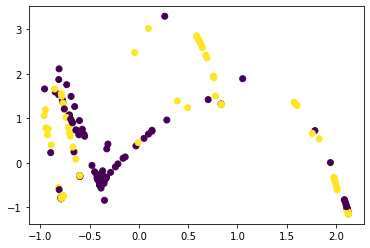

In [4]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
plt.scatter(X[:,1], X[:,2],c=train_labels)
plt.show()

In [5]:
n_qubits = len(X[0])
n_qubits

3

In [6]:
dev_kernel = qml.device("default.qubit", wires=n_qubits)

projector = np.zeros((2**n_qubits, 2**n_qubits))
projector[0, 0] = 1

@qml.qnode(dev_kernel)
def kernel(x1, x2):
    """The quantum kernel."""
    AngleEmbedding(x1, wires=range(n_qubits))
    qml.adjoint(AngleEmbedding)(x2, wires=range(n_qubits))
    return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))

In [7]:
kernel(X[0], X[0])

tensor(1., requires_grad=True)

In [8]:
def kernel_matrix(A, B):
    """Compute the matrix whose entries are the kernel
       evaluated on pairwise data from sets A and B."""
    return np.array([[kernel(a, b) for b in B] for a in A])

In [9]:
svm = SVC(kernel=kernel_matrix).fit(X, train_labels)

In [10]:
# Load Test data
df = pd.read_csv (r'./mock_test_set.csv')
test_data = df.iloc[:,[i for i in range(4)]].to_numpy()
test_labels = df.iloc[:, 4].to_numpy()
test_labels = 2 * (test_labels - 0.5)
print(test_data , test_labels)

[[2.98855e+03 1.00000e+04 1.00000e+04 7.50000e+01]
 [3.41380e+03 1.00000e+00 1.00000e+02 9.00000e+01]
 [3.89152e+03 1.00000e+00 1.00000e+00 5.00000e+00]
 [4.51499e+03 1.00000e+04 1.00000e+06 2.50000e+01]
 [7.52290e+02 1.00000e+01 1.00000e+01 9.00000e+01]
 [1.40413e+03 1.00000e+04 1.00000e+03 5.00000e+00]
 [3.39065e+03 1.00000e+06 1.00000e+04 5.00000e+00]
 [2.62098e+03 1.00000e+00 1.00000e+01 7.50000e+01]
 [2.05960e+02 1.00000e+01 1.00000e+02 1.50000e+01]
 [1.49575e+03 1.00000e+04 1.00000e+04 8.00000e+01]
 [2.41590e+02 1.00000e+04 1.00000e+05 1.00000e+01]
 [4.01638e+03 1.00000e+06 1.00000e+03 4.50000e+01]
 [7.21820e+02 1.00000e+00 1.00000e+00 3.50000e+01]
 [5.76980e+02 1.00000e+00 1.00000e+02 4.00000e+01]
 [4.85430e+03 1.00000e+03 1.00000e+01 7.00000e+01]
 [4.82122e+03 1.00000e+03 1.00000e+06 8.50000e+01]
 [2.39061e+03 1.00000e+06 1.00000e+06 6.00000e+01]
 [3.75672e+03 1.00000e+06 1.00000e+05 6.50000e+01]
 [4.70472e+03 1.00000e+03 1.00000e+01 5.00000e+00]
 [3.75746e+03 1.00000e+02 1.000

In [11]:
pca_test = PCA(n_components=k)
test_data = normalize(test_data)
print("Fitting Data....")
pca_test.fit(test_data)
print("Variance Ratio = ", pca_test.explained_variance_ratio_)
print("Variance Ratio Cumulative = ", sum(pca_test.explained_variance_ratio_))
X_test = pca_test.transform(test_data)
test_scaler = StandardScaler()
test_scaler.fit(X_test)
X_test = test_scaler.transform(X_test)

Fitting Data....
Variance Ratio =  [0.70445591 0.279145   0.01313534]
Variance Ratio Cumulative =  0.996736253775483


In [12]:
predictions = svm.predict(X_test)
print(predictions)
accuracy_score(predictions, test_labels)

[ 1.  1.  1.  1.  1. -1. -1.  1.  1.  1.  1. -1.  1.  1.  1.  1. -1. -1.
  1.  1. -1. -1. -1.  1.  1.  1.  1. -1.  1.  1.  1.  1. -1.  1. -1. -1.
  1. -1.  1.  1. -1.  1.  1. -1.  1. -1.  1. -1.  1.  1.  1.  1.  1.  1.
 -1. -1.  1. -1. -1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1. -1.  1. -1.
  1.  1.  1.  1. -1.  1. -1.  1. -1.  1.  1. -1.  1.  1. -1.  1.  1. -1.
 -1.  1. -1. -1. -1.  1.  1.  1. -1.  1.  1.  1.  1. -1. -1.  1.  1. -1.
  1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.]


0.15833333333333333

In [13]:
print(test_labels)

[ 1. -1. -1.  1. -1.  1.  1. -1. -1.  1.  1.  1. -1. -1. -1.  1.  1.  1.
 -1. -1.  1.  1.  1.  1. -1. -1. -1.  1. -1.  1. -1.  1.  1. -1.  1.  1.
 -1.  1. -1. -1.  1. -1. -1.  1. -1.  1.  1.  1.  1. -1. -1. -1. -1. -1.
  1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1.  1.  1.  1. -1.  1. -1.  1.
  1. -1. -1. -1.  1. -1.  1. -1.  1.  1. -1.  1. -1. -1.  1. -1. -1.  1.
  1. -1.  1.  1.  1. -1. -1. -1.  1.  1. -1. -1. -1.  1.  1.  1. -1.  1.
  1.  1. -1.  1. -1.  1. -1.  1. -1. -1. -1. -1.]
